In [1]:
import sys, os, importlib

# --- Paths ---
current_dir = os.getcwd()  # This will be .../DeepOMAPNet/Notebooks
project_root = os.path.dirname(current_dir)  # This will be .../DeepOMAPNet

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Added to Python path:")
print(f"- Current directory: {current_dir}")
print(f"- Project root: {project_root}")
print(f"- Scripts directory exists: {os.path.exists(os.path.join(project_root, 'scripts'))}")
print(f"- Scripts/data_provider exists: {os.path.exists(os.path.join(project_root, 'scripts', 'data_provider'))}")

# Clear any cached imports
importlib.invalidate_caches()

# --- Import modules (module-style, not from ... import ...) ---
import scripts.data_provider.data_preprocessing as data_preprocessing
import scripts.data_provider.graph_data_builder as graph_data_builder
import scripts.model.doNET as doNET
import scripts.trainer.gat_trainer as gat_trainer

print("Module imports successful!")

Added to Python path:
- Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Tutorials
- Project root: /projects/vanaja_lab/satya/DeepOMAPNet
- Scripts directory exists: True
- Scripts/data_provider exists: True


/home/nandivada.s/.conda/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Module imports successful!


In [2]:
import scanpy as sc
GSE559 = sc.read_h5ad("/projects/vanaja_lab/satya/DeepOMAPNet/GSE232559.h5ad")
GSE559


AnnData object with n_obs × n_vars = 29925 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'counts'

In [6]:
import pandas as pd
import numpy as np
import gzip
from scipy import io
import scanpy as sc

# 1. Read protein (ADT) features
with gzip.open('/projects/vanaja_lab/satya/Datasets/GSE232559/GSE232559_totalvi_denoised_adt_features.tsv.gz', 'rt') as f:
    features = pd.read_csv(f, sep='\t', header=None)[0].tolist()

# 2. Read ADT matrix (features x cells)
with gzip.open('/projects/vanaja_lab/satya/Datasets/GSE232559/GSE232559_totalvi_denoised_adt.mtx.gz', 'rt') as f:
    mtx = io.mmread(f)

# 3. If you have barcodes for df rows, use them; otherwise, confirm no order mismatch!
# For best practice, set barcodes if available:
# with open('/projects/vanaja_lab/satya/Datasets/GSE232559/GSE232559_cell_barcodes.txt') as f:
#     barcodes = [line.strip() for line in f]
#     df = pd.DataFrame(mtx.T.toarray(), columns=features, index=barcodes)
# Otherwise just use range index:
df = pd.DataFrame(mtx.T.toarray(), columns=features)

# ------------------- NEW STEP: EXTRACT AS DATAFRAME -------------------
# If you've already assigned, this works for any AnnData in this format:

# Extract the protein matrix as a DataFrame with proper labels
protein_df = pd.DataFrame(
    df.iloc[:29925].values, 
    index=GSE559.obs_names,                 # Cells as rows
    columns=df.columns     # Proteins as columns
)




In [7]:
import numpy as np
import pandas as pd

def clr_normalize(df):
    # CLR: log(x) - mean(log(x)) per row
    # Add a small pseudocount to avoid log(0)
    pseudocount = 1e-6
    log_df = np.log1p(df + pseudocount)
    clr_df = log_df.sub(log_df.mean(axis=1), axis=0)
    return clr_df

# Assuming protein_df is your DataFrame of shape (n_cells, n_proteins)
protein_df_clr= clr_normalize(protein_df)
protein_df_clr


,CD4,CD7,CD56,CD3,CD33,CD34,CD90,CD117,CD45RA,CD123,...,CD11b,CD64,CD38,CD45,CD36,CD93,CD9,CD19,CD70,CD27
barcode,,,,,,,,,,,,,,,,,,,,,
AML-03_AAAGAACAGGTGCCTC,0.073531,0.136836,-0.051732,-0.121950,0.236101,0.248107,-0.139635,0.134435,0.175910,0.191479,...,-0.039058,0.096105,0.327993,0.354423,0.264534,0.064418,0.313847,-0.210498,-1.513180,-0.338609
AML-03_AAAGAACCAACGGCTC,-0.006700,0.234060,-0.058826,-0.116022,0.186532,0.317846,-0.100466,0.116865,0.200660,0.264573,...,-0.201353,-0.037358,0.363914,0.376010,0.241017,0.090968,0.355312,-0.177863,-1.471900,-0.344444
AML-03_AAAGAACGTATTGGCT,0.037615,0.199791,-0.054751,-0.118254,0.240688,0.332048,-0.098273,0.157029,0.182939,0.227720,...,-0.113125,-0.013075,0.279982,0.339781,0.291886,0.082116,0.251112,-0.189260,-1.458896,-0.360460
AML-03_AAAGGATAGACATATG,0.041150,0.175282,-0.067611,-0.140972,0.234567,0.308515,-0.120886,0.099212,0.195045,0.231980,...,-0.028225,0.031586,0.258101,0.353464,0.303415,0.076497,0.273963,-0.205800,-1.418186,-0.370903
AML-03_AAAGGGCAGGTTCATC,0.021628,0.176129,-0.054716,-0.113197,0.238899,0.280364,-0.108285,0.154191,0.178861,0.215283,...,-0.181258,0.048009,0.357132,0.330425,0.250183,0.086883,0.248476,-0.183010,-1.409956,-0.338901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt-89_Dx_TTTCCTCTCCTTGACC,0.443962,0.489651,-0.018227,0.482704,-0.136756,-0.094945,-0.046097,-0.112397,0.343212,0.019250,...,-0.327173,-0.156710,0.114260,0.594973,0.223810,0.065983,0.090760,-0.137472,-1.453253,0.055502
Pt-89_Dx_TTTGACTAGGTGCATG,0.461120,0.490301,-0.012429,0.489053,-0.118240,-0.080756,-0.035136,-0.110754,0.328741,0.027489,...,-0.330606,-0.161102,0.103142,0.597208,0.222070,0.068578,0.063943,-0.135062,-1.449839,0.052202
Pt-89_Dx_TTTGATCGTCACCGCA,0.157645,-0.134769,-0.041905,-0.124990,0.322260,-0.033462,-0.123244,-0.179153,0.168124,0.194213,...,0.150595,0.250929,0.369748,0.406062,0.296436,0.121075,0.234759,-0.229281,-1.317631,-0.340738


In [8]:
# Randomly select 10,000 cell indices (rows)
selected_indices = np.random.choice(GSE559.n_obs, size=10000, replace=False)

# Subset the AnnData object
GSE559 = GSE559[selected_indices].copy()

print(GSE559)

AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'counts'


In [9]:
# Convert AnnData to PyTorch Geometric format
print("=== Converting to PyTorch Geometric Format ===")
from scripts.data_provider.graph_data_builder import build_pyg_data
# Convert RNA data
print("Converting RNA data...")
rna_pyg_data = build_pyg_data(GSE559)
print(f"RNA PyG data: {rna_pyg_data}")




=== Converting to PyTorch Geometric Format ===
Converting RNA data...
build_pyg_data called with use_pca=True
Input adata shape: (10000, 2000)
Available obsm keys: ['X_scVI']
Computing PCA with exactly 50 components...
PCA computed, shape: (10000, 50)
Computing neighbor graph first...
Computing leiden clusters first...
Using PCA features, shape: (10000, 50)
RNA PyG data: Data(x=[10000, 50], edge_index=[2, 107815], y=[10000])


In [14]:
import torch
import sys
import os
from scripts.model.doNET import EnhancedGATWithTransformerFusion

# Set up your paths if needed
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)


model = EnhancedGATWithTransformerFusion(
    in_channels=2000,           
    hidden_channels=32,         
    out_channels=279,           
    heads=2,                     
    dropout=0.6,                 
    nhead=2,                    
    num_layers=1,               
    use_adapters=True,
    reduction_factor=4,
    adapter_l2_reg=5e-5,       
    use_positional_encoding=True,
    num_cell_types = 54
)

# Load the saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("DeepOMAPNet_weights.pth", map_location=device))


# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [15]:
import torch
import scipy.sparse as sp

rna_test_subset = GSE559

# 1. Convert sparse matrix to dense PyTorch tensor
if sp.issparse(rna_test_subset.X):
    rna_features = torch.tensor(rna_test_subset.X.toarray(), dtype=torch.float32)
else:
    rna_features = torch.tensor(rna_test_subset.X, dtype=torch.float32)

# 2. Extract edge_index from PyG Data objects (not the objects themselves)
# rna_pyg_data is a PyG Data object, so you need its .edge_index attribute
edge_index_rna = rna_pyg_data.edge_index  # This is the actual [2, E] tensor



# 3. Make predictions
model.eval()
with torch.no_grad():
    adt_predictions, aml_predictions, fused_embeddings = model(
        x=rna_features,  # [N, 36601] - already a tensor
        edge_index_rna=edge_index_rna,  # [2, E] - from rna_pyg_data.edge_index
        edge_index_adt=None  # [2, E] - from adt_pyg_data.edge_index (or None)
    )

# Extract cell type predictions from fused embeddings
    celltype_logits = model.predict_celltypes(fused_embeddings)  # [N, 54]
    celltype_probs = torch.softmax(celltype_logits, dim=-1)      # [N, 54]
    celltype_pred_idx = celltype_probs.argmax(dim=1).cpu().numpy()  # [N] - class indices



# 4. Convert to numpy
adt_predictions_np = adt_predictions.cpu().numpy()
aml_probabilities = torch.sigmoid(aml_predictions).cpu().numpy()

print(f"ADT predictions shape: {adt_predictions_np.shape}")
print(f"AML probabilities shape: {aml_probabilities.shape}")

ADT predictions shape: (10000, 279)
AML probabilities shape: (10000, 1)


In [16]:
print("Creating predictions AnnData object...")

# Copy the input AnnData (GSE559) and attach predictions
predictions = GSE559.copy()
# Update X (expression matrix) only if ADT predictions are what you want here; otherwise, remove this line
# predictions.X = adt_predictions_np  # Only if you'd like to overwrite, e.g., X with predicted ADT

# Add AML probability and predicted AML class
aml_probs = aml_probabilities.flatten()  # (100,)
predictions.obs['aml_probability'] = aml_probs
predictions.obs['predicted_aml_class'] = (aml_probs > 0.5).astype(str)
predictions.obs['predicted_aml_class'] = predictions.obs['predicted_aml_class'].replace({'True': 'pAML', 'False': 'pNormal'})

# Add fused embeddings to obsm (n_cells x hidden_dim)
predictions.obsm['X_fused_embeddings'] = fused_embeddings.cpu().numpy()  # (100, hidden_dim)

print("Predictions AnnData created:")
print(predictions)


Creating predictions AnnData object...
Predictions AnnData created:
AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels', 'leiden', 'aml_probability', 'predicted_aml_class'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'pca', 'neighbors', 'leiden'
    obsm: 'X_scVI', 'X_pca', 'X_fused_embeddings'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [18]:
import scanpy as sc
import anndata


# Load the preprocessed data
from scripts.data_provider.data_preprocessing import prepare_train_test_anndata
data = prepare_train_test_anndata()
rna_adata = data[0]  # RNA data
rna_test = data[1]
adt_adata = data[2]   # ADT data
adt_test = data[3]





All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train: ['Control4003', 'Control1', 

In [19]:
adt_predictions_np

adt_predictions= pd.DataFrame(
    adt_predictions_np, 
    index=GSE559.obs_names,                 # Cells as rows
    columns=adt_test.to_df().columns     # Proteins as columns
)


In [20]:
true_adt = protein_df_clr
true_adt.shape

(29925, 22)

In [60]:
adt_predictions.shape

(10000, 279)

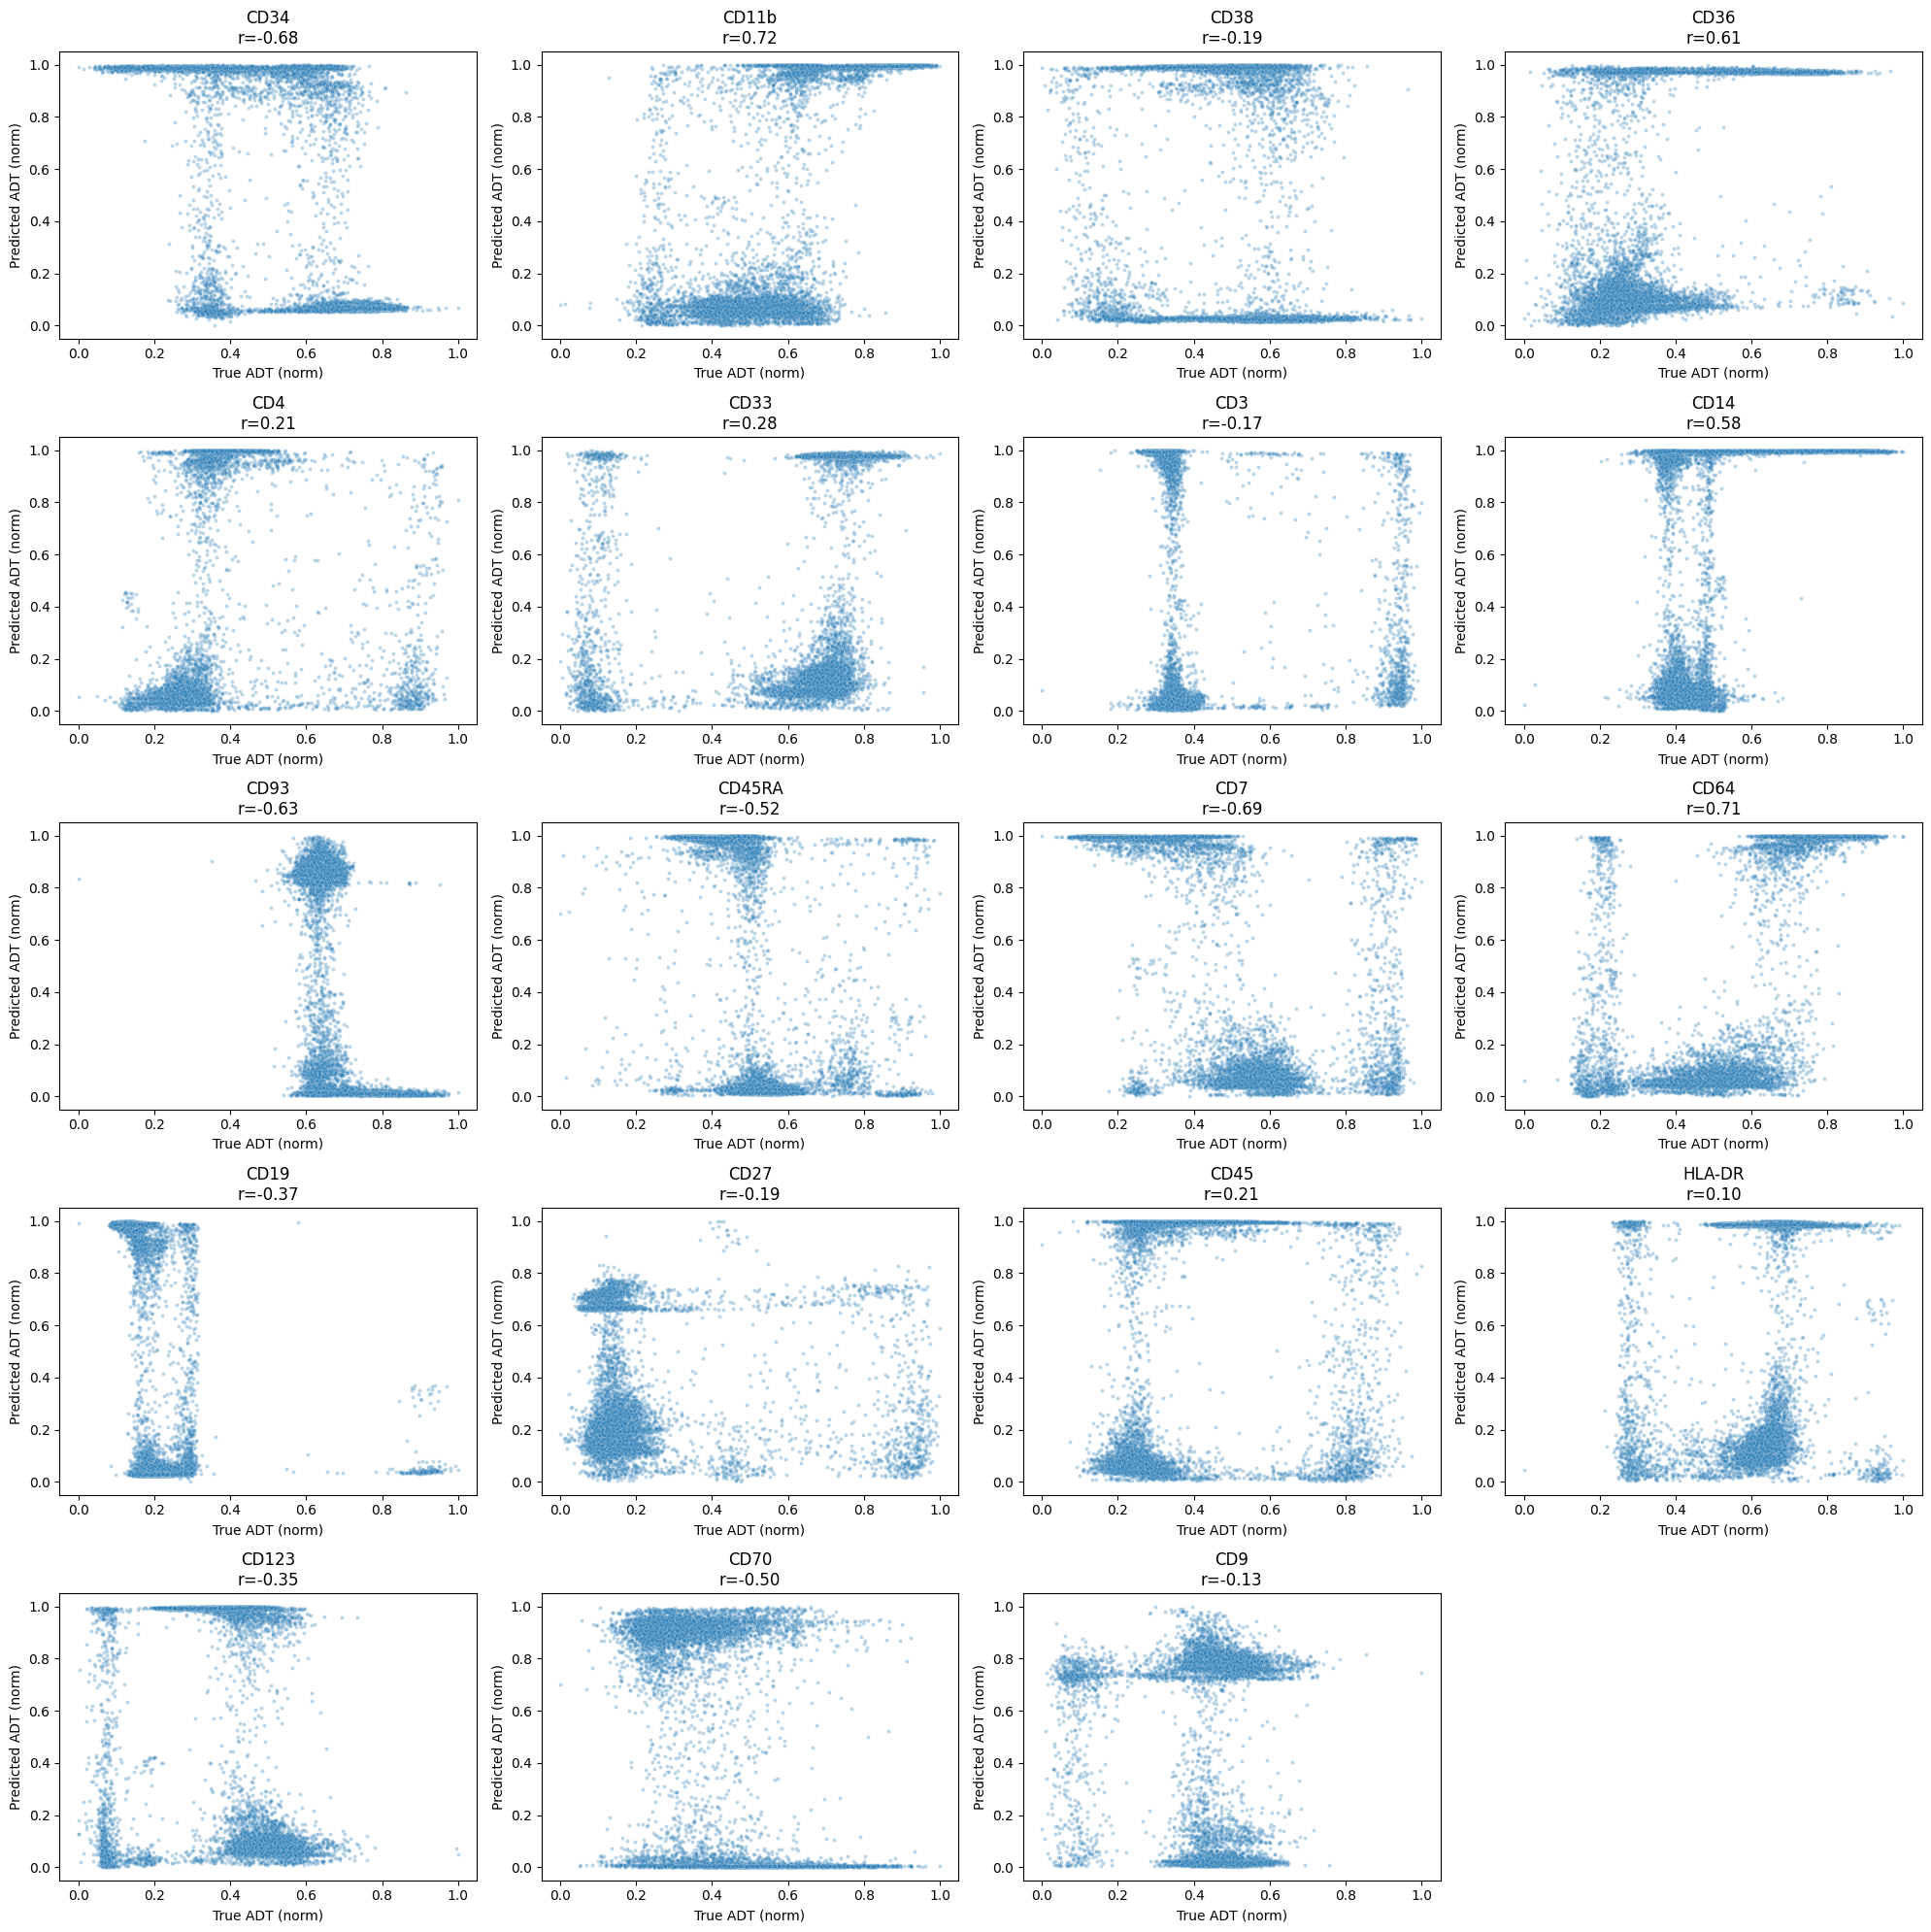

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Find matched columns and common cell indices
common_cols = list(set(true_adt.columns) & set(adt_predictions.columns))
common_idx = list(set(true_adt.index) & set(adt_predictions.index))

# 2. Align both DataFrames by columns and indices
true_aligned = true_adt.loc[common_idx, common_cols]
pred_aligned = adt_predictions.loc[common_idx, common_cols]

# 3. Min-Max normalization to [0, 1]
scaler = MinMaxScaler()
true_norm = pd.DataFrame(scaler.fit_transform(true_aligned), index=true_aligned.index, columns=true_aligned.columns)
pred_norm = pd.DataFrame(scaler.fit_transform(pred_aligned), index=pred_aligned.index, columns=pred_aligned.columns)

# 4. Plot correlation for each matched column
num_cols = len(common_cols)
fig, axes = plt.subplots(nrows=(num_cols + 3) // 4, ncols=4, figsize=(20, 4 * ((num_cols + 3) // 4)))
axes = axes.flatten()

for i, col in enumerate(common_cols):
    sns.scatterplot(
        x=true_norm[col],
        y=pred_norm[col],
        ax=axes[i],
        s=8,
        alpha=0.3
    )
    corr = pd.Series(true_norm[col]).corr(pd.Series(pred_norm[col]))
    axes[i].set_title(f"{col}\nr={corr:.2f}")
    axes[i].set_xlabel("True ADT (norm)")
    axes[i].set_ylabel("Predicted ADT (norm)")

for ax in axes[num_cols:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


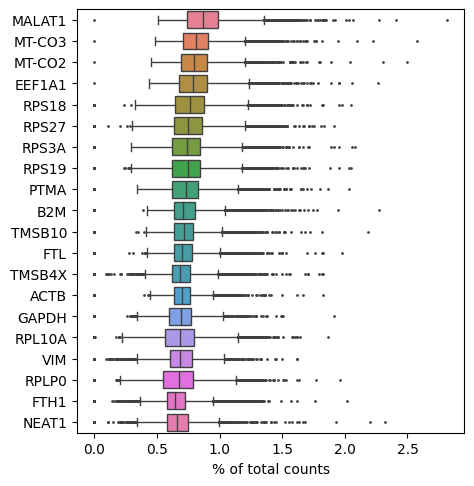

In [22]:
sc.pl.highest_expr_genes(predictions, n_top=20)

Computing PCA from fused embeddings...


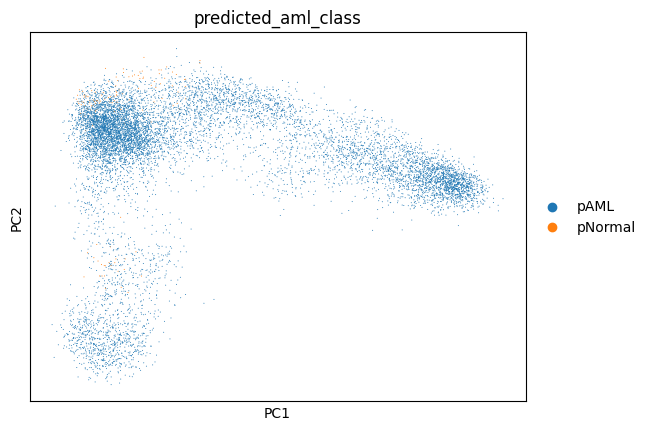

In [23]:
# Compute PCA using fused embeddings
print("Computing PCA from fused embeddings...")

# Store original embeddings
fused_embeddings = predictions.obsm['X_fused_embeddings'].copy()

# Compute PCA using scanpy
sc.pp.pca(predictions, n_comps=50, use_highly_variable=False)

sc.pl.pca(
    predictions,
    color=["predicted_aml_class"],
    size=2,
)




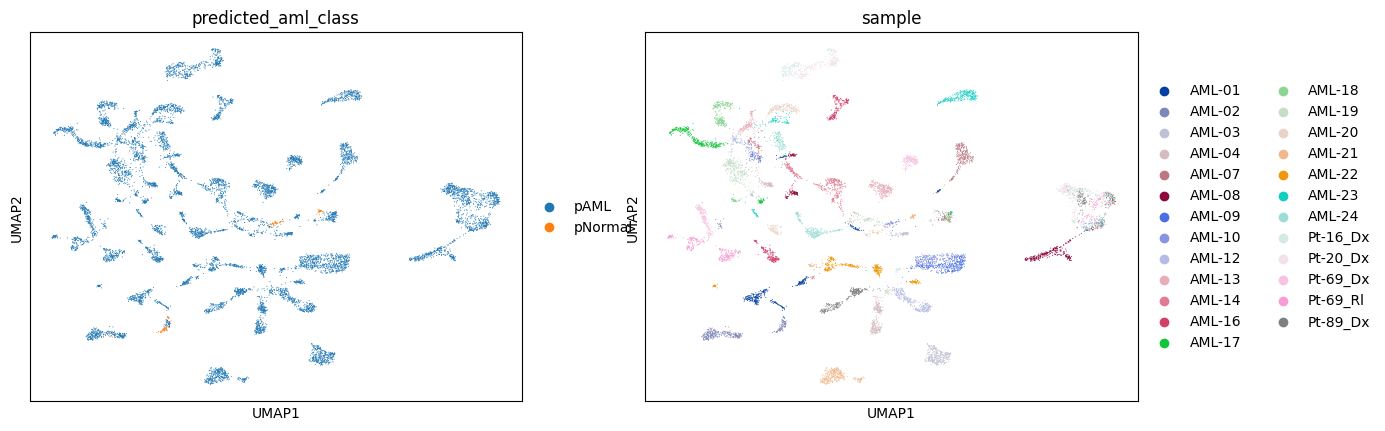

In [24]:

sc.tl.umap(predictions)

sc.pl.umap(
    predictions,
    color=["predicted_aml_class","sample"],
    size=2,
)

In [25]:
predictions

AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels', 'leiden', 'aml_probability', 'predicted_aml_class'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'predicted_aml_class_colors', 'umap', 'sample_colors'
    obsm: 'X_scVI', 'X_pca', 'X_fused_embeddings', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'